In [22]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np

In [38]:
def build_circuit(n_qubits, depth, gate_params):
    """Build a quantum circuit and convert it to an MPO."""
    # Initialize the quantum circuit
    circuit = qtn.Circuit(n_qubits)

    for layer in range(depth):
        # Apply single-qubit RX rotations
        for i in range(n_qubits):
            theta = gate_params['single'][layer, i]
            circuit.apply_gate('rx', theta, i)

        # Apply two-qubit RZZ gates (nearest neighbors)
        for i in range(n_qubits - 1):
            angle = gate_params['rzz'][layer, i, i + 1]
            circuit.apply_gate('rzz', angle, i, i + 1)

    # Convert the circuit to an MPO
    #mpo = circuit.to_mpo()
    return circuit


(<Figure size 366.667x100 with 1 Axes>, <Axes: >)

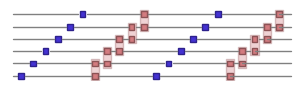

In [44]:

n_qubits = 6
depth = 2
params = {
    'single': np.random.uniform(0, 2*np.pi, (depth, n_qubits)),
    'rzz': np.random.uniform(0, 2*np.pi, (depth, n_qubits, n_qubits))
}

circuit = build_circuit(n_qubits, depth, params)
circuit.draw()

In [ ]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np

def rx_matrix(theta, i):
    data = qu.expm(-1j * theta / 2 * qu.pauli('X'))
    return qtn.Tensor(data, inds = f'b{i}', f'o{i}')

def rzz_matrix(theta, i, j):
    ZZ = np.kron(qu.pauli('Z'), qu.pauli('Z'))
    data = qu.expm(-1j * theta / 2 * ZZ)
    gate = qtn.Tensor(data)
    gate = gate.split()
    return 


def build_mpo(n_qubits, depth, params):
    """Build compressed MPO with explicit gate tensors"""
    # Initialize empty MPO
    mpo = qtn.MPO_identity(n_qubits, dtype='complex64')

    print(mpo)
    
    for layer in range(depth):
        # Single-qubit RX gates
        for i in range(n_qubits):
            theta = params['single'][layer, i]
            gate = rx_matrix(theta).astype('complex64')
            
            # Add as diagonal tensor in MPO

            mpo[]
            
            mpo.add_tensor(qtn.Tensor(
                data=gate,
                inds=(f'k{i}', f'k{i}'),  # Diagonal in MPO space
                tags=[f'site{i}', 'rx']
            ))

        mpo.contract()
        
        # All-to-all ZZ gates
        for i in range(n_qubits):
            for j in range(i+1, n_qubits):
                theta = params['zz'][layer, i, j]
                gate = rzz_matrix(theta).astype('complex64')
                #gate = gate.split([f'k{i}', f'k{j}', f'k{i}', f'k{j}'])
                
                # Create 4-index tensor for ZZ interaction
                zz_tensor = qtn.Tensor(
                    data=gate.reshape(2,2,2,2),  #This should be SVD
                    inds=(f'k{i}', f'k{j}', f'k{i}', f'k{j}'),
                    tags=[f'site{i}', f'site{j}', 'zz']
                )
                mpo.add_tensor(zz_tensor)
            mpo.contract()
        
        # Compress after each layer
        mpo.compress(cutoff=1e-6, max_bond=32,)
    mpo.contract()
    return mpo

n_qubits = 6
depth = 2
params = {
    'single': np.random.uniform(0, 2*np.pi, (depth, n_qubits)),
    'zz': np.random.uniform(0, 2*np.pi, (depth, n_qubits, n_qubits))
}

mpo = build_mpo(n_qubits, depth, params)
mpo

MatrixProductOperator([
    Tensor(shape=(1, 2, 2), inds=('_61417fAAAqu', 'k0', 'b0'), tags=oset(['I0'])),
    Tensor(shape=(1, 1, 2, 2), inds=('_61417fAAAqu', '_61417fAAAqv', 'k1', 'b1'), tags=oset(['I1'])),
    Tensor(shape=(1, 1, 2, 2), inds=('_61417fAAAqv', '_61417fAAAqw', 'k2', 'b2'), tags=oset(['I2'])),
    Tensor(shape=(1, 1, 2, 2), inds=('_61417fAAAqw', '_61417fAAAqx', 'k3', 'b3'), tags=oset(['I3'])),
    Tensor(shape=(1, 1, 2, 2), inds=('_61417fAAAqx', '_61417fAAAqy', 'k4', 'b4'), tags=oset(['I4'])),
    Tensor(shape=(1, 2, 2), inds=('_61417fAAAqy', 'k5', 'b5'), tags=oset(['I5'])),
], tensors=6, indices=17, L=6, max_bond=1)


MatrixProductOperator(tensors=48, indices=17, L=6, max_bond=2)

In [ ]:
def apply_mpo_to_state(mpo, initial_state):
    """Apply the MPO to an initial state represented as an MPS."""
    # Create MPS from the initial computational basis state
    mps = qtn.MPS_computational_state(initial_state)
    # Apply the MPO to the MPS
    result_mps = mpo @ mps
    return result_mps

(3, 3, 2, 2)

array([[[[1., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[1., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[1., 0.],
         [0., 1.]]]])

In [ ]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np

def swap_gate():
    """Returns the SWAP gate as a (2,2,2,2) tensor."""
    SWAP = np.array([[1, 0, 0, 0], 
                     [0, 0, 1, 0], 
                     [0, 1, 0, 0], 
                     [0, 0, 0, 1]])
    return SWAP

def rzz(theta):
    """Create the RZZ gate matrix."""
    ZZ = np.kron(qu.pauli('Z'), qu.pauli('Z'))
    return qu.expm(-1j * theta / 2 * ZZ)


def decompose_two_qubit_gate(gate):
    gate = np.reshape(gate, (2,2,2,2))
    gate = np.transpose(gate, (0,2,1,3))
    gate = np.reshape(gate, (4,4))

    U, S, Vh = np.linalg.svd(gate)  
    S_diag = np.diag(S)  
    bd = len(S)
    print(S)

    # Absorb sqrt(S) into U and Vh to get two-site tensors
    U_new = U @ np.sqrt(S_diag)
    Vh_new = np.sqrt(S_diag) @ Vh

    U_new = (U_new.T).reshape(1, -1, 2, 2)
    Vh_new = Vh_new.reshape(-1, 1, 2, 2)

    return U_new, Vh_new, bd

def create_non_local_gate_mpo(gate, i, j, N):
    tensors = []
    for _ in range(i):
        tensors.append(np.reshape(np.eye(2),(1,1,2,2)))
    
    U, V, bd = decompose_two_qubit_gate(gate)

    if i==0: tensors.append(U.reshape((-1,2,2)))
    else: tensors.append(U)

    delta_ij = np.eye(bd)
    delta_ab = np.eye(2)
    I = np.einsum('ij,ab->ijab', delta_ij, delta_ab)

    for _ in range(i+1,j):
        tensors.append(I)

    if j==N-1: tensors.append(V.reshape((-1,2,2)))
    else: tensors.append(V)

    mpo = qtn.MatrixProductOperator(tensors)

    return mpo








# Number of qubits
n = 6  

# Create an identity MPO
id_mpo = qtn.MPO_identity(n)

# Define parameters
theta = np.pi / 4  # Example rotation angle
i, j = 1, 4  # Non-adjacent qubits (0-based)

# Get RZZ gate
rzz_gate = rzz_matrix(theta)

U, Vh = decompose_two_qubit_gate(rzz_gate)

In [ ]:
rand_mpo = qtn.MPO_rand(6, bond_dim=4)

tensors = [np.random.randn(4,2,2)]
tensors.append(np.random.randn(4,4,2,2))
tensors.append(np.random.randn(4,5,2,2))
tensors.append(np.random.randn(5,1,2,2))
tensors.append(np.random.randn(1,1,2,2))
tensors.append(np.random.randn(1,4,2,2))
tensors.append(np.random.randn(4,2,2))

mpo = qtn.MatrixProductOperator(tensors)

ValueError: axes don't match array

In [171]:
mpo.trace()

-517.8616254103656

In [173]:
def Singular_values(mpo,i):
    #Returns singular values of an MPO at i'th site
    A = mpo[i].data
    chi = A.shape[1]  #Bond Dimension
    A = np.transpose(A, (0,2,3,1))
    A = np.reshape(A, (-1,chi))

    B = mpo[i+1].data
    B = np.reshape(B, (chi,-1))

    S = np.linalg.svd(A@B, compute_uv=False)
    return S

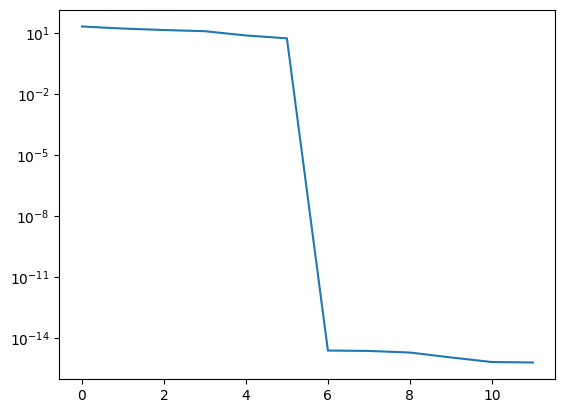

In [175]:
import matplotlib.pyplot as plt
plt.semilogy(Singular_values(mpo, 3))

In [87]:
id_mpo = qtn.MPO_identity(n)

In [89]:
id_mpo.show()

│1│1│1│1│1│
●─●─●─●─●─●
│ │ │ │ │ │


In [ ]:
id_mpo[0] = 